In [2]:
from manim import *
import pandas as pd
import jupyter_capture_output

video_scene = " -v WARNING --disable_caching writing_visualization_Scene"
image_scene = f" -v WARNING --disable_caching -r {2*427},{2*240}  -s writing_visualization_Scene"

Jupyter Capture Output v0.0.11


In [27]:
# data processing

# total writing data
writing_data = pd.read_csv(f"../external_media/Raw_Sample_Data_Report_Plus_Segs_Report_ERSERO0_segmentiert0.txt", delimiter = "\t", skiprows = 0, skipinitialspace = True).dropna(subset = "seg_path")
# reduce writing data to kinetic energy
kin_energy_writing_data = writing_data.loc[writing_data["seg_path"].str.contains('ERSERO0->kinEnergie')]
# add an integer time to the dataframe
kin_energy_writing_data["integer_time"] = kin_energy_writing_data["time"]*1000
kin_energy_writing_data["integer_time"] = kin_energy_writing_data["integer_time"].astype(int) 
kin_energy_writing_data

# pause data


/tmp/ipykernel_192651/1218280764.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kin_energy_writing_data["integer_time"] = kin_energy_writing_data["time"]*1000
/tmp/ipykernel_192651/1218280764.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kin_energy_writing_data["integer_time"] = kin_energy_writing_data["integer_time"].astype(int)


,index,time,x,y,pressure,state,x_filtered,y_filtered,pressure_filtered,x_velocity,...,segment_id,status,series_id,run_id,stroke_id,stroke_type,seg_level,seg_path,seg_name,integer_time
5056,5056,206.940,9246,35384,112,24,9246.0,35384.0,112.0,1.256202,...,7,"['FIRST_PRESS', 'PRESSED']",10,68,83,0,2.0,ERSERO0->kinEnergie,E,206940
5057,5057,206.947,9246,35384,592,16,9246.0,35384.0,592.0,0.477689,...,7,['PRESSED'],10,68,83,0,2.0,ERSERO0->kinEnergie,E,206947
5058,5058,206.955,9246,35384,1088,16,9246.0,35384.0,1088.0,0.139569,...,7,['PRESSED'],10,68,83,0,2.0,ERSERO0->kinEnergie,E,206955
5059,5059,206.962,9246,35384,1616,16,9246.0,35384.0,1616.0,0.076590,...,7,['PRESSED'],10,68,83,0,2.0,ERSERO0->kinEnergie,E,206962
5060,5060,206.970,9246,35384,2128,16,9246.0,35384.0,2128.0,0.181402,...,7,['PRESSED'],10,68,83,0,2.0,ERSERO0->kinEnergie,E,206970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5778,5778,212.371,13756,34857,6707,16,13756.0,34857.0,6707.0,37.380578,...,16,['PRESSED'],10,78,91,0,3.0,ERSERO0->kinEnergie->v2,2,212371
5779,5779,212.379,13792,34857,6627,16,13792.0,34857.0,6627.0,33.837746,...,16,['PRESSED'],10,78,91,0,3.0,ERSERO0->kinEnergie->v2,2,212379
5780,5780,212.386,13827,34857,6338,16,13827.0,34857.0,6338.0,30.322885,...,16,['PRESSED'],10,78,91,0,3.0,ERSERO0->kinEnergie->v2,2,212386
5781,5781,212.394,13856,34857,4610,16,13856.0,34857.0,4610.0,26.814769,...,16,['PRESSED'],10,78,91,0,3.0,ERSERO0->kinEnergie->v2,2,212394


In [122]:
class SegPath(Mobject):
    def __init__(self, center, main_height, seg_data, **kwargs):
        super().__init__(**kwargs)
        self.center = center
        self.seg_data = seg_data

        # process writing data
        self.integer_time_data = seg_data["integer_time"]
        self.x_data = seg_data["x"]
        self.y_data = seg_data["y"]
        self.pressure_data = seg_data["pressure"]
        self.seg_name_data = seg_data["seg_name"]

        # set geometry of main frame
        x_data_range = max(self.x_data) - min(self.x_data)
        y_data_range = max(self.y_data) - min(self.y_data)
        print(x_data_range, y_data_range)

        self.main_height = main_height
        self.main_width = float(self.main_height) / y_data_range * x_data_range
        print(self.main_height, self.main_width)

        # main coordinate system
        self.main_npla = NumberPlane(
            x_range = (min(self.x_data)-x_data_range/10, max(self.x_data)+x_data_range/10, 100), y_range = (min(self.y_data)-y_data_range/2.5, max(self.y_data)+y_data_range/2.5, 100), x_length = self.main_width, y_length = self.main_height,
            x_axis_config = {"stroke_opacity": 0.215}, y_axis_config = {"stroke_opacity": 0.125}, background_line_style = {"stroke_opacity": 0.125}
        ).move_to(self.center)
        self.main_rect = Rectangle(width = self.main_width, height = self.main_height, stroke_width = 1, stroke_color = WHITE).move_to(self.center)
        self.main_square = Square(color = WHITE)
        # self.add(self.main_npla)
        self.add(self.main_rect)


    # returns the dot at position i
    def get_dot(self, int_time):
        if (int_time in self.integer_time_data.values):
            int_time_column = self.seg_data[self.seg_data["integer_time"] == int_time]
            pressure = int(int_time_column["pressure"].iloc[0])
            if pressure < 100:
                return 0
            else:
                x_i = float(int_time_column["x"].iloc[0])
                y_i = float(int_time_column["y"].iloc[0])
                write_dot = Dot(radius = 0.025, color = RED).move_to(self.main_npla.c2p(x_i, y_i, 0))
                return write_dot

Manim Community v0.18.1

4837 1550
3 9.361935483870967
206940
206947
206955
206962
206970
206977
206985
206992
207000
207007
207015
207022
207030
207037
207045
207052
207060
207067
207075
207082
207090
207098
207105
207113
207120
207128
207135
207143
207150
207158
207165
207173
207180
207188
207195
207203
207210
207218
207225
207233
207240
207248
207255
207263
207270
207278
207285
207293
207300
207308
207316
207323
207544
207551
207559
207566
207574
207581
207589
207596
207604
207611
207619
207732
207739
207747
207754
207762
207769
207777
207784
207792
207799
207807
207814
208272
208279
208287
208294
208302
208309
208317
208324
208332
208339
208347
208354
208492
208499
208507
208514
208522
208529
208537
208544
208552
208559
209012
209019
209027
209034
209042
209049
209057
209064
209072
209079
209087
209094
209102
209109
209117
209124
209132
209139
209147
209154
209162
209169
209177
209185
209192
209200
209207
209215
209222
209388
209395
209403
209410
209418
209425
209433
209440
209448
209455
209463
209470
2094

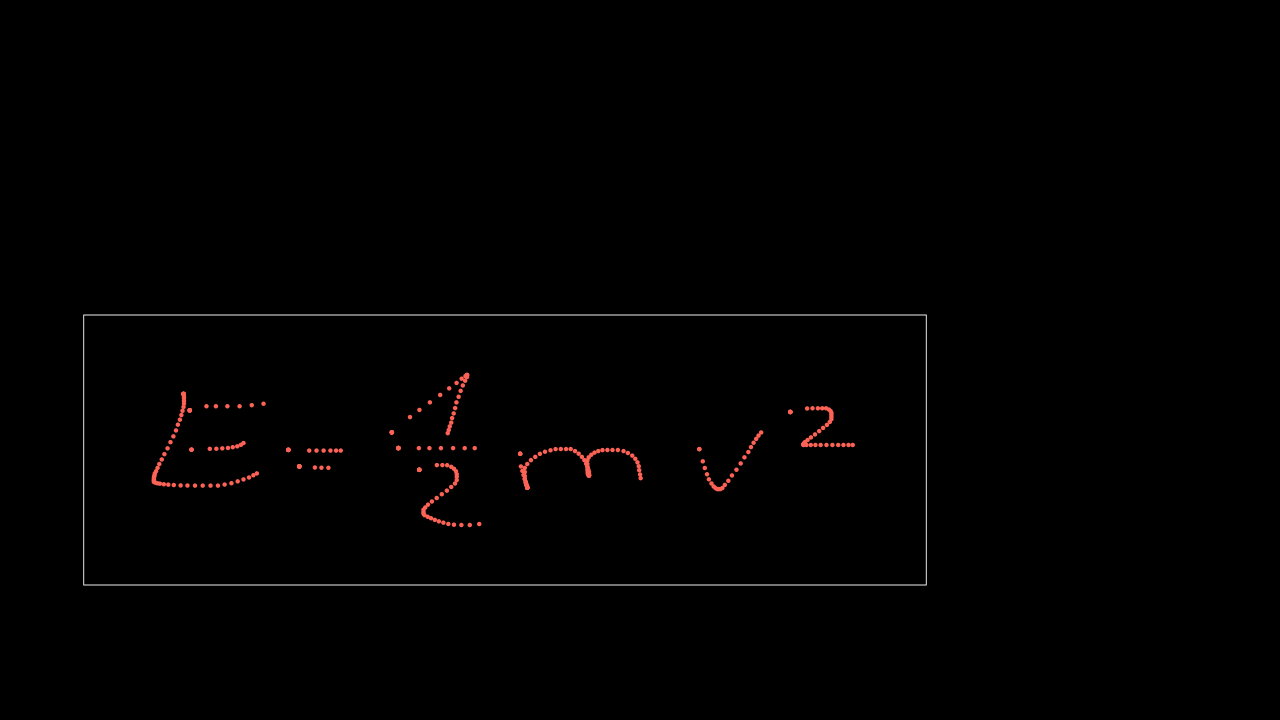

In [123]:
%%manim -qm --fps 60 $video_scene


class writing_visualization_Scene(Scene):
    def construct(self):

        # main path parameters
        main_path_center = np.array([-1.5, -1, 0])
        main_path_height = 3

        seg_path = SegPath(main_path_center, main_path_height, kin_energy_writing_data)
        self.add(seg_path)

        min_time = min(kin_energy_writing_data["integer_time"])
        max_time = max(kin_energy_writing_data["integer_time"])
        for int_time in range(min_time, max_time):
            dot = seg_path.get_dot(int_time)
            if dot:
                print(int_time)
                self.add(dot)
            # self.wait(1.0/60)